In [2]:
from datetime import datetime
import numpy as np
import pandas as pd
import torch
from torch.optim.lr_scheduler import StepLR
from sklearn.model_selection import train_test_split


In [3]:
df = pd.read_csv("merged_dataset.csv",index_col=0)
df

,Title,Author,Series,Lang,Label
0,Book Author,NaN,NaN,English,Indian
1,Making India Awesome,Chetan Bhagat,NaN,English,Indian
2,One Indian Girl,Chetan Bhagat,NaN,English,Indian
3,Half Girlfriend,Chetan Bhagat,NaN,English,Indian
4,Revolution 2020,Chetan Bhagat,NaN,English,Indian
...,...,...,...,...,...
883,A Child\,NaN,NaN,NaN,Non-Indian
884,A Childs history of England,Dickens Charles,NaN,English,Non-Indian
885,A Child\,NaN,NaN,NaN,Non-Indian
886,A Child\,NaN,NaN,NaN,Non-Indian


In [4]:
df = df.drop(df[(df['Label'] == 'Non-Indian') & (df.index > 500)].index)

In [5]:
df = df.sample(frac=1)

In [6]:
df['Label'] = df['Label'].replace({'Indian':1,'Non-Indian':0})

In [7]:
df

,Title,Author,Series,Lang,Label
497,1st To Die,Patterson James,The Women\,NaN,0
336,2061,Clarke Arthur C,Odyssey 3,English,0
176,Glimpses of World History,Jawaharlal Nehru,NaN,English,1
433,17 Dialogue On The Way Of Knowledge Part VI,Castaneda Carlos,NaN,English,0
105,Kashmir: A Tale of Shame,Hari Jaisingh,NaN,English,1
...,...,...,...,...,...
437,18 Essays and Short Fiction,Blish James,NaN,English,0
338,2061,Clarke Arthur C,Odyssey 3,English,0
361,3001,Clarke Arthur C,Odessey 4,English,0
9,A Passage to England,Nirad C. Chaudhuri,NaN,English,1


In [8]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [9]:
train_df

,Title,Author,Series,Lang,Label
487,1984,Orwell George,NaN,English,0
434,17 24,Bisson Terry,NaN,English,0
262,47,Mosley Walter,NaN,English,0
346,3001,Clarke Arthur C,Odessey 4,English,0
221,Black Warrant (book),Sunetra Choudhury,NaN,English,1
...,...,...,...,...,...
95,Inscrutable Americans,Anurag Mathur,NaN,English,1
365,(Serious) Actualism and (Serious) Presentism,Bergmann Michael,NaN,English,0
250,Why There Are No Noyontara Flowers In Agargaon...,Shahidul Zahir,NaN,English,1
456,1813 The Rivers of War,Flint Eric,TOG 1,English,0


In [10]:
val_df

,Title,Author,Series,Lang,Label
31,An Autobiography,Jawaharlal Nehru,NaN,English,1
141,Saket,Maithili Sharan Gupt,NaN,English,1
206,Dhammapada (Easwaran translation),NaN,NaN,English,1
287,1633,Flint Eric; Weber David,Ring of Fire 2,English,0
218,Bhavsagar Granth,NaN,NaN,English,1
...,...,...,...,...,...
415,1634 The Ram Rebellion,Flint Eric,Ring of Fire 4,English,0
100,Junglee Girl,Ginu Kamani,NaN,English,1
44,Chemmeen,Thakazhi Sivasankara Pillai,NaN,English,1
429,1635 The Dreeson Incident,Flint Eric; DeMarce Virginia,NaN,English,0


In [11]:
import torch
# from transformers import RobertaTokenizer, RobertaForSequenceClassification
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
!pip3 install emoji==0.6.0


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [12]:
train_titles = train_df["Title"].values
val_titles = val_df["Title"].values

train_authors = train_df["Author"].values
val_authors = val_df["Author"].values

train_series = train_df["Series"].values
val_series = val_df["Series"].values

train_lang = train_df["Lang"].values
val_lang = val_df["Lang"].values

train_labels = train_df["Label"].values
val_labels = val_df["Label"].values

In [21]:
def construct_prompt(title, author, series, lang):
    prompt = "The title of the book is " + str(title) + ", and the author is " + str(author) + ". The book is from the " + str(series) + " series.\
 The book is written in " + str(lang) + ". Is the book's context Indian or Non-Indian?"

    return prompt

In [22]:
print("Example prompt:\n",construct_prompt("Pather Panchali","Bibhuti Bhushan","NaN","English"))

Example prompt:
 The title of the book is Pather Panchali, and the author is Bibhuti Bhushan. The book is from the NaN series. The book is written in English. Is the book's context Indian or Non-Indian?


In [23]:
class CustomDataset(Dataset):
    def __init__(self, titles, authors, series, langs, labels, tokenizer, max_length):
        self.titles = titles
        self.authors = authors
        self.series = series
        self.langs = langs
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.titles)

    def __getitem__(self, idx):
        text = construct_prompt(self.titles[idx],self.authors[idx],self.series[idx],self.langs[idx])
        label = float(self.labels[idx])
        if(label==0.0):
            label = [1.0,0.0]
        elif(label==1.0):
            label = [0.0,1.0]
            
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.float32)
        }

In [68]:
tokenizer = AutoTokenizer.from_pretrained('roberta-base')
model = AutoModelForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

criterion = nn.CrossEntropyLoss()

train_dataset = CustomDataset(train_titles, train_authors, train_series, train_lang, train_labels, tokenizer, max_length=128)
val_dataset = CustomDataset(val_titles, val_authors, val_series, val_lang, val_labels, tokenizer, max_length=128)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [69]:
num_epochs = 1
optimizer = optim.Adam(model.parameters(), lr=1e-5)
losses = []
# scheduler = StepLR(optimizer, step_size=456, gamma=1/3)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    with tqdm(total=len(train_loader), desc=f"Epoch {epoch + 1}/{num_epochs}", unit='batch') as progress_bar:
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            loss.backward()
            optimizer.step()
            # scheduler.step()

            running_loss += loss.item()
            progress_bar.set_postfix({'loss': running_loss / (progress_bar.n + 1)})
            losses.append(running_loss/(progress_bar.n + 1))
            progress_bar.update(1)

    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch + 1}/{num_epochs}] Loss: {epoch_loss}")

Epoch 1/1: 100%|██████████| 25/25 [04:24<00:00, 10.58s/batch, loss=0.597]

Epoch [1/1] Loss: 0.5974012994766236


## Training notes

This is what is done during calculation of loss in the output of the model. The point is that the model forward function automatically computes output and computes the loss since you also input the label.

```
if labels is not None:
    if self.num_labels == 1:
        #  We are doing regression
        loss_fct = MSELoss()
        loss = loss_fct(logits.view(-1), labels.view(-1))
    else:
        loss_fct = CrossEntropyLoss()
        loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
    outputs = (loss,) + outputs
```

Note that CrossEntropyLoss() function never requires you to apply softmax beforehand. It does a softmax on the logits before. So the logits you see aren't the ones that the loss is computed on. Either way, this will work for training and evaluation.

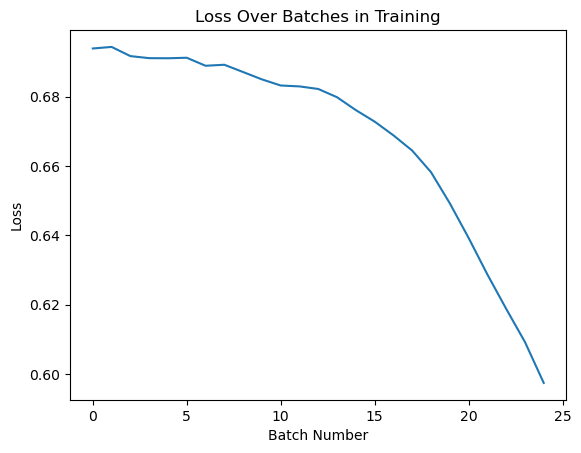

In [103]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.title('Loss Over Batches in Training')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.show()


In [71]:
model.eval()
val_loss = 0.0
ans = []
labs = []
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        logits = outputs.logits
        # ans.extend(outputs.logits)
        # labs.extend(labels)
        loss = outputs.loss
        val_loss += loss.item()

average_val_loss = val_loss / len(val_loader)
print(f"Validation Loss: {average_val_loss}")

Validation Loss: 0.2508840837648937


In [72]:
torch.save(model, 'model_save.pth')

# Model testing

In [74]:
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

train_dataset = CustomDataset(train_titles, train_authors, train_series, train_lang, train_labels, tokenizer, max_length=128)
val_dataset = CustomDataset(val_titles, val_authors, val_series, val_lang, val_labels, tokenizer, max_length=128)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [76]:
model = torch.load('model_save.pth')

In [77]:
model.to(device)

cnt = 0
ans = []
labs = []
batch_order=[]

model.eval()
val_loss = 0.0
with torch.no_grad():
    for i,batch in enumerate(val_loader):
        cnt += 32
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        ans.extend(outputs.logits)
        labs.extend(labels)
        loss = outputs.loss
        val_loss += loss.item()

average_val_loss = val_loss / len(val_dataset)
print(f"Validation Loss: {average_val_loss}")

Validation Loss: 0.01738800580548768


In [90]:
import math
predicted_arr = []
j = 0
cl_pred=[]
cl_actual=[]

for i in ans:
    cl = np.argmax(nn.Softmax(dim=0)(i)).item()
    if(cl==1):
        cl_pred.append("Indian")
    else:
        cl_pred.append("Non-Indian")

for i in labs:
    cl = np.argmax(nn.Softmax(dim=0)(i)).item()
    if(cl==1):
        cl_actual.append("Indian")
    else:
        cl_actual.append("Non-Indian")

In [102]:
mistake=0
for i in range(len(cl_pred)):
    pred = cl_pred[i]
    act = cl_actual[i]
    if(pred!=act):
        mistake+=1
        print("Mistake:",i)

assert len(cl_pred)==len(cl_actual)
print("Number of elements:",len(cl_pred))
correct = len(cl_pred) - mistake
print("Accuracy: ", (len(cl_pred)-mistake)*100/len(cl_pred), "%")

Mistake: 66
Mistake: 92
Number of elements: 101
Accuracy:  98.01980198019803 %


## Model prediction

In [110]:
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

In [111]:
def get_args(title,author,series,lang):
    text = construct_prompt(title,author,series,lang)
        
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=128,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    return {
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten()
    }

In [145]:
title = input("Enter title: ")
author = input("Enter author: ")
series = input("Enter series (NA=not applicable): ")
lang = input("Enter language: ")

args = get_args(title,author,series,lang)
args['input_ids'] = args['input_ids'].unsqueeze(0)
args['attention_mask']=args['attention_mask'].unsqueeze(0)

output = model(input_ids=args['input_ids'],attention_mask=args['attention_mask']).logits[0]
label = np.argmax(nn.Softmax(dim=0)(output).detach().numpy())
out_label = "Indian" if label==1 else "Non-Indian"
print(out_label)

Indian
